In [1]:
import os
import glob
import quaxed.numpy as qnp

import tinygp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

# from astropy import units as u, constants as c
from astropy.time import Time
from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

In [5]:
S=2.36
w=0.0195
Q=7.63
sigma = jnp.sqrt(S*w*Q)

qsSHO = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)

# Use tinygp to define a 'ground truth' process

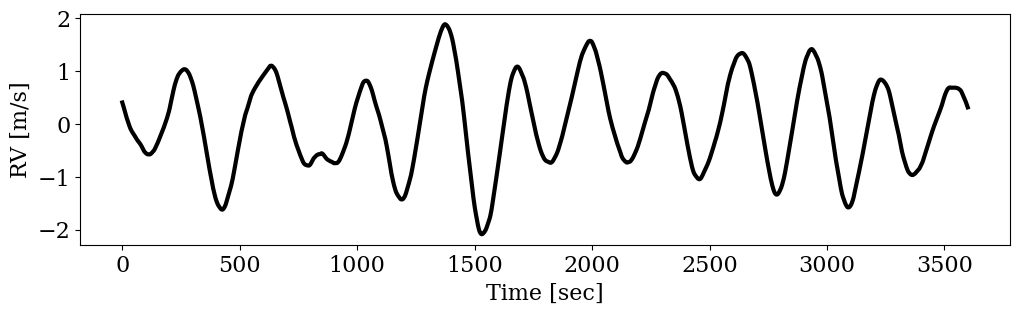

In [6]:
def get_true_gp(tmax, tunit='s', dt=1):
    t = u.Quantity(jnp.arange(0, tmax, dt), tunit).to('s').value
    true_gp = tinygp.GaussianProcess(qsSHO, t)
    # gp.sample adds small random noise for numerical stability
    y_sample = true_gp.sample(key=jax.random.PRNGKey(32)) 
    f = make_smoothing_spline(t, y_sample, lam=10/60)
    return t, f

t, f = get_true_gp(60, 'min', dt=1/60)
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(t, f(t), label='Example SHO', color='k', lw=3)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

## Make synthetic observations

In [7]:
#### Simulated dataset
N = 30
yerr = 0.3 # m/s

np.random.seed(231)
t_train = jnp.linspace(t.min(), t.max(), N)

y_true = f(t_train)
y_train = y_true + yerr * jax.random.normal(key, shape=(N,))


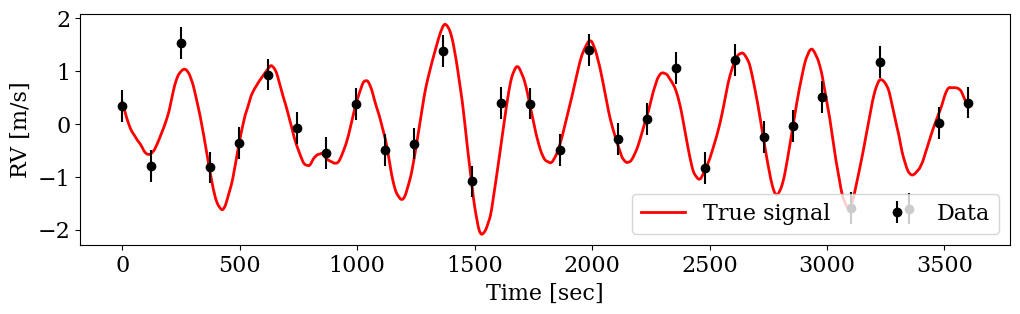

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
ax.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data')

ax.legend(ncol=2)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

## Build the model with ``ssmolgp``

In [9]:
import ssmolgp

In [10]:
ssSHO = ssmolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)

In [11]:
R = jnp.full(N, yerr**2)
noise = tinygp.noise.Diagonal(R)
ssm_solver = ssmolgp.solvers.StateSpaceSolver(ssSHO, t_train,
                                               y_train, noise)

In [82]:
conditioned_results = ssm_solver.condition()

## unpack into prediction at data points
(m_predicted, P_predicted), \
(m_filtered, P_filtered), \
(m_smoothed, P_smoothed), v_S = conditioned_results

# Maybe there's a better way to do this
H  = jax.vmap(ssSHO.observation_model)(t_train)

# Project predictive mean/var to observation space
ks = jnp.arange(N)

y_ss = jax.vmap(lambda k: H[k]@m_smoothed[k])(ks).squeeze()
yvar_ss = jax.vmap(lambda k: H[k]@P_smoothed[k]@H[k].T)(ks).squeeze()
yerr_ss = jnp.sqrt(yvar_ss)

In [ ]:
t_test = jnp.linspace(t.min(), t.max(), 500)

mu_ss, var_ss = ssm_solver.predict(t_test, conditioned_results)
std_ss = jnp.sqrt(var_ss)

### Full GP prediction

In [85]:
diag = yerr**2 

shokern = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
gp = tinygp.GaussianProcess(shokern, t_train, diag=diag)
y_gp, yvar_gp = gp.predict(y_train, t_train, kernel=shokern, return_var=True)
mu_gp, var_gp = gp.predict(y_train, t_test,  kernel=shokern, return_var=True)
yerr_gp = jnp.sqrt(yvar_gp)
std_gp  = jnp.sqrt(var_gp)

### Plot

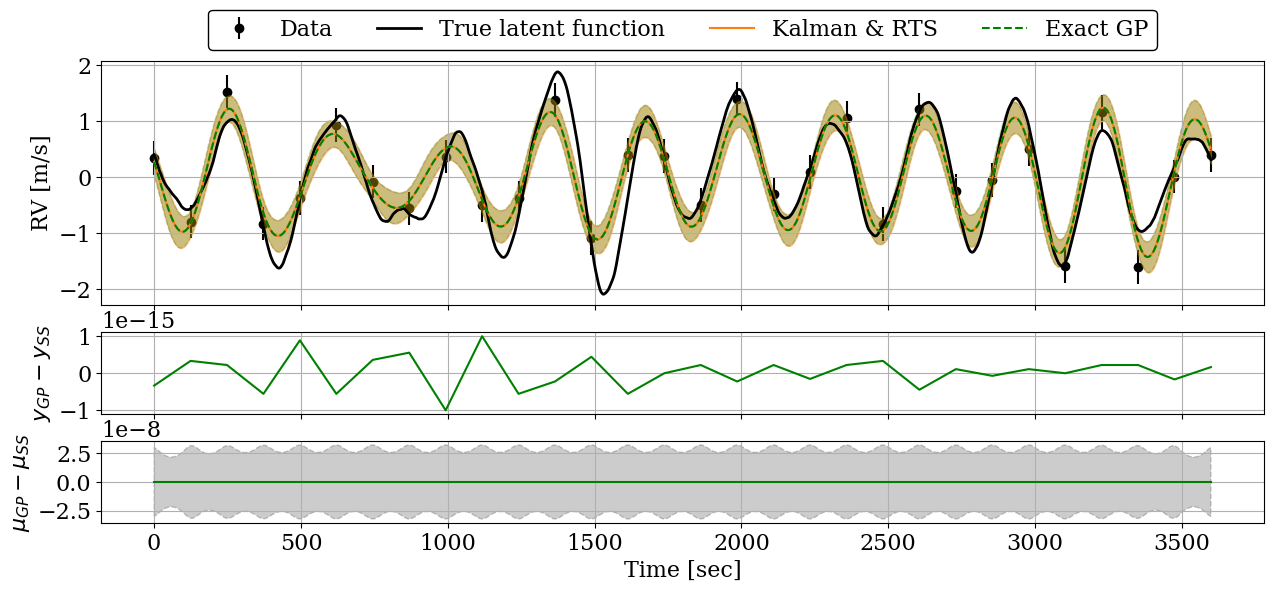

In [ ]:
fig, (ax, rax1, rax2) = plt.subplots(3,1, figsize=(15, 6), sharex=True, gridspec_kw={'height_ratios':[3,1,1]})

cobs = 'k' # 'w'
ctrue = 'k'
cgp  = 'g'
ckal = 'C0'
crts = 'C1'

## Data and true signal
l1 = ax.errorbar(t_train, y_train, yerr, fmt='o', zorder=0, color=cobs, label="Data")
l2, = ax.plot(t, f(t), color=ctrue, lw=2, label="True latent function")

## Kalman filtered result
# l3, = ax.plot(t_train, y_kal, 'o', color=ckal,  ls=':',  label="Kalman Filtered Mean")
# ax.fill_between(t_train, y_kal-yerr_kal, y_kal+yerr_kal, color=ckal, alpha=0.2)

# ## RTS smoothed result
# l4, = ax.plot(t_train, y_ss, 'o', color=crts,  ls='-', label="RTS Smoothed Mean")
# ax.fill_between(t_train, y_ss-yerr_ss, y_ss+yerr_ss, color=crts, alpha=0.2)

# ## GP solution
# l5, = ax.plot(t_train, y_gp, 'o', color=cgp,   ls='-',  label="Exact GP Mean")
# ax.fill_between(t_train, y_gp-yerr_gp, y_gp+yerr_gp, color=cgp, alpha=0.2)

## Test predictions
l4, = ax.plot(t_test, mu_ss, color=crts,  ls='-', label="Kalman & RTS")
ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, ls='-', color=crts, alpha=0.4)

l5, = ax.plot(t_test, mu_gp,  color=cgp,   ls='--',  label="Exact GP")
ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, ls='--', color=cgp, alpha=0.2)

lines = [l1, l2, l4, l5]
ax.legend(lines, [l.get_label() for l in lines],
            ncol=4,# loc='upper center', #fontsize=14,
            loc='lower center', bbox_to_anchor=[0.5,1],
              framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
# ax.set_title("State-Space GP vs. Exact GP")
ax.set(ylabel='RV [m/s]', )#xlim=[max(t_test.min(), t.min().to(kernel.tunit).value),
                        #  min(t_test.max(), t.max().to(kernel.tunit).value)])
# ax.set_ylim(f(t).min()-.2, f(t).max()+1)
ax.grid()

# rax.plot(t_train, y_kal-y_true, ckal, ls=':')
rax1.plot(t_train, y_gp-y_ss,  cgp , ls='-')
# rax1.plot(t_train, )

mu_true = f(t_test/60)
rax2.plot(t_test, mu_gp-mu_ss, c=cgp , ls='-')
# rax2.fill_between(t_test, (mu_ss-std_ss) - (mu_gp-std_gp), 
#                           (mu_ss+std_ss) - (mu_gp+std_gp), 
#                   ls='--', color='k', alpha=0.2)

rax1.set(ylabel=r'$y_{GP}-y_{SS}$')
rax2.set(xlabel='Time [sec]', ylabel=r'$\mu_{GP}-\mu_{SS}$')

rax1.grid();rax2.grid();

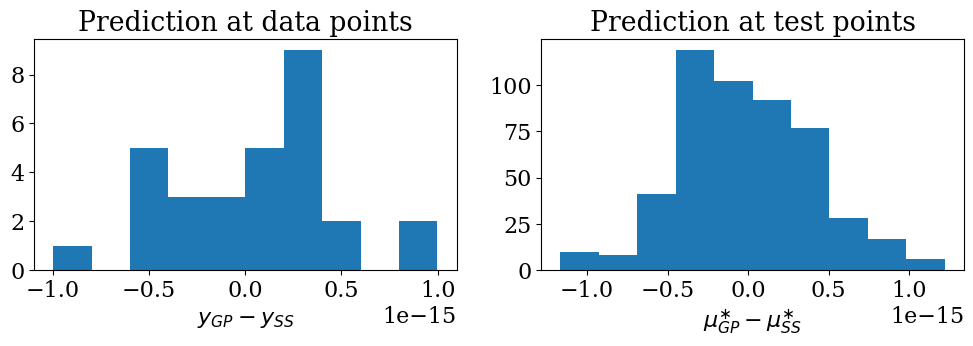

In [98]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.hist(y_gp - y_ss);
# ax1.hist(yvar_gp - yvar_ss);
ax1.set(title='Prediction at data points', xlabel='$y_{GP} - y_{SS}$')

ax2.hist(mu_gp - mu_ss);
# ax2.hist(var_gp - var_ss);
ax2.set(title='Prediction at test points', xlabel=r'$\mu^{\ast}_{GP} - \mu^{\ast}_{SS}$');

# 6. Timed benchmark comparison

In [42]:
import time

In [43]:
t.shape

(720,)

In [44]:
def get_stuff(N):

    if N<200:
        times = jnp.sort(np.random.uniform(t.value.min(), t.value.max(), N))
        y_true = f(times)
    else:
        # Split into 200 points per day
        times = jnp.linspace(t.value.min(), t.value.max(), 200)
        y_true = jnp.tile(f(times), N//200 + 1)[:N]
        times  = jnp.hstack([day*1440 + times for day in range(N//200+1)])[:N]

    tobs = u.Quantity(times, t.unit)
    t_train = tobs.to(kernel.tunit).value # times in unit of the kernel (for computing Delta) 
    y_train = y_true + yerr * jax.random.normal(key, shape=(N,))

    # Time grid for making the prediction
    t_test = t_train
    # t_test = jnp.linspace(0, t.value.max(), 1000)

    return tobs, t_train, y_train, t_test

In [45]:
recompute = False
# recompute = True

In [46]:
if recompute:
    tss = []
    tgp = []
    tqs = []

    Ns = np.logspace(1, 6, 11).astype(int)

    for N in Ns:

        tobs, t_train, y_train, t_test = get_stuff(N)

        # Kalman filters/RTS smooth/projection
        tstart = time.time()
        m_filtered, P_filtered, m_predicted, P_predicted = kalman_filter(H, R, t_train, y_train, m0, P0)
        m_smooth, P_smooth = rts_smoother(t_train, m_filtered, P_filtered, m_predicted, P_predicted)
        # filt_mean   = (H @ m_filtered.T).squeeze()
        # filt_var    = (H @ P_filtered @ H.T).squeeze()
        # smooth_mean = (H @ m_smooth.T).squeeze()
        # smooth_var  = (H @ P_smooth @ H.T).squeeze()
        m_smooth.block_until_ready(); P_smooth.block_until_ready()
        tend = time.time()
        tss.append(tend-tstart)

        if N<=5e4:
            # GP exact posterior for comparison
            tstart = time.time()
            # # gp_mean, gp_cov = gp_posterior(t_train, y_train, t_test, noise_var)
            # # gp_std = jnp.sqrt(jnp.diag(gp_cov))
            gp = tinygp.GaussianProcess(kernel, tobs, diag=diag)
            gp_mean, gp_cov = gp.predict(y_train, tobs, return_var=True)
            gp_mean.block_until_ready(); gp_cov.block_until_ready();
            tend = time.time()
            tgp.append(tend-tstart)
        else:
            tgp.append(np.nan)

        # quasisep GP for comparison
        tstart = time.time()
        # gp_mean, gp_cov = gp_posterior(t_train, y_train, t_test, noise_var)
        # gp_std = jnp.sqrt(jnp.diag(gp_cov))
        gp = tinygp.GaussianProcess(shokern, t_train, diag=diag)
        gp_mean, gp_cov = gp.predict(y_train, return_var=True)
        gp_mean.block_until_ready(); gp_cov.block_until_ready();
        tend = time.time()
        tqs.append(tend-tstart)

    tss = np.array(tss)
    tgp = np.array(tgp)
    tqs = np.array(tqs)

    np.savez('ss_vs_gp_timing.npz', Ns=Ns, tss=tss, tgp=tgp, tqs=tqs)
else:
    timing_data = np.load('ss_vs_gp_timing.npz')
    Ns  = timing_data['Ns']
    tss = timing_data['tss']
    tgp = timing_data['tgp']
    tqs = timing_data['tqs']

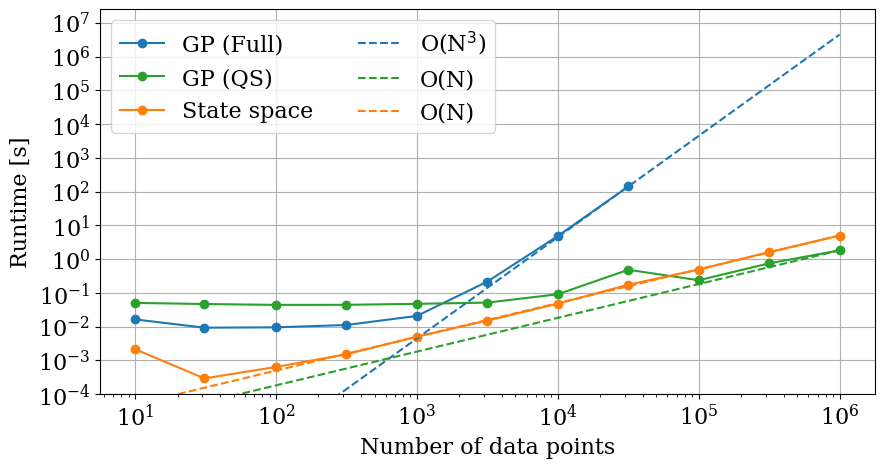

In [47]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(Ns, tgp, 'o-', color='C0', label='GP (Full)')
ax.plot(Ns, tqs, 'o-', color='C2', label='GP (QS)')
ax.plot(Ns, tss, 'o-', color='C1', label='State space')

Nss = np.logspace(1, 6, 100)
idxgp = np.where(~np.isnan(tgp))[0][-1]
ax.plot(Nss, tgp[idxgp]*(Nss/Ns[idxgp])**3, ls='--', color='C0',  label='O(N$^3$)')
ax.plot(Nss, tqs[-1]*(Nss/Ns[-1]),    ls='--', color='C02', label='O(N)')
ax.plot(Nss, tss[-1]*(Nss/Ns[-1]),    ls='--', color='C1',  label='O(N)')
ax.legend(ncol=2)

ax.set(xlabel='Number of data points', ylabel='Runtime [s]',
       xscale='log', yscale='log')
ax.set_ylim(bottom=max(ax.get_ylim()[0], 1e-4))

from matplotlib.ticker import LogLocator
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=len(Ns)))
ax.grid()
plt.savefig('/Users/rrubenzahl/Desktop/figures/ss_vs_gp_benchmark.png', dpi=300, bbox_inches='tight')

### Helper function to check we're initializing correctly

In [48]:
def check_initial_covariance(F, L, Qc, H, P0, kernel_var_expected, tol=1e-6):
    """
    Check if initial state covariance P0 and kernel variance match.

    Args:
        F, L, Qc, H: state-space model matrices
        P0: initial covariance matrix (d x d)
        kernel_var_expected: scalar kernel variance k(0,0)
        tol: tolerance for numerical check

    Prints comparison and returns True if consistent.
    """
    # Compute initial output variance implied by P0
    initial_var = (H @ P0 @ H.T).item()
    print(f"Kernel variance at t=0: {kernel_var_expected:.6g}")
    print(f"Initial covariance projected to output space: {initial_var:.6g}")

    # Check closeness
    if jnp.abs(initial_var - kernel_var_expected) > tol:
        print("WARNING: Initial covariance P0 does NOT match kernel variance within tolerance.")
        return False
    else:
        print("Initial covariance P0 matches kernel variance within tolerance.")
    return True


kernel_var = shokern(jnp.array([0.0]), jnp.array([0.0]))[0,0]
consistent = check_initial_covariance(F, L, Qc, H, P0, kernel_var)

Kernel variance at t=0: 0.351133
Initial covariance projected to output space: 0.351133
Initial covariance P0 matches kernel variance within tolerance.


# 7. Exposure-integrated observations

## 7.1 Traditional GP approach
Handling exposure-integrated observations, especially when observations are allowed to overlap, requires significant bookkeeping. In the traditional GP framework, the cross-covariance between two datapoints $t_i$ and $t_j$ with exposure times $\delta_i$ and $\delta_j$ is:
\begin{align*}
k_{F,F}(t_i,t_j,\delta_i,\delta_j) = \frac{1}{\delta_i \delta_j} \int_{t_i-\delta_i/2}^{t_i+\delta_i/2} \int_{t_j-\delta_j/2}^{t_j+\delta_j/2} k(t,t') dt dt'. \tag{7.1}
\end{align*}
As Luhn et al. (in prep) show, special care is needed to handle partially overlapping observations as the two integrals become coupled for that overlapping period. For the case of fully separated observations, as well as perfectly overlapping observations (such as an observation with itself, i.e. the diagonal), the integral yields a closed-form analytic solution. These two cases can then be combined with appropriate weighting along the non-overlapping and shared segments of partially overlapping observations to correctly recover the joint covariance for arbitrary overlap. However, the logic needed to implement this in practice prevents the use of quasiseparable linear algebra, even if the underlying kernel is stationary and quasiseparable, for the simple reason that the overlapping observations live near to the diagonal (in a time-ordered matrix) without exploitable structure (they also do not form a LEAF ([Delisle et al. 2021](https://www.aanda.org/articles/aa/full_html/2022/03/aa41949-21/aa41949-21.html)) matrix). 

Datastreams generated by a single instrument, in general, should not have any overlapping observations. It would then be possible to represent the integrated GP kernel in quasiseparable form in that case. For example, an integrated SHO kernel can be expressed as the sum of four SHO kernels at shifted times and modified amplitudes, and two constant terms, each of which is compatible with a quasiseparable form. However, combining data from multiple instruments during shared observing windows will often yield overlapping pairs of observations. In that case, the GP formalism is cursed to rely on dense matrix computations. In general though, for realistic datasets, overlapping observations represent a small fraction of the total number of datapoints (and certainly a small fraction of all the possible pairs of observations), so the dense matrix representation (while formally correct) is an overly cumbersome way to deal with this problem.

### Aside/move to "intro"

Previous works in the state space formalism have treated integrated measurements as an integrated observation model and integrated process noise over the exposure [e.g., Qian and Chang 2021](https://www.sciencedirect.com/science/article/abs/pii/S0263224121002268). While this works, it involves very gross integrals. See past version of this notebook for the math (pre 9/18/2025).

## 7.2 State space approach

$\providecommand{\pm}{}$
$\renewcommand{\pm}[1]{\begin{pmatrix}#1\end{pmatrix}}$

The state space formalism allows for a more elegant solution (which preserves the O(N) time complexity *and* is compatible with the parallel method) by integrating the dynamics, rather than the covariance.

Let $y_n$ be the exposure-averaged measurement at observation $n \in [1,N]$, 
\begin{align*}
y_n &= \frac{1}{\delta_n} \int_{t^s_n}^{t^e_n}H_n f(\tau)d\tau + \epsilon_n.   \tag{7.2}
\end{align*}
where $t^s_n$ and $t^e_n$ are the start and stop times of the exposure, with length $\delta_n = t^e_n - t^s_n$. Because integration is a linear operator, it preserves the linear, Gaussian nature of the state space system ([S&auml;rkk&auml; 2011](https://users.aalto.fi/~ssarkka/pub/spde.pdf)). Moreover, our state is generally already the joint state of the instantaneous latent state and its first $d-1$ time derivatives. We can thus introduce the integral state $z$ such that
\begin{align*}
\frac{dz}{dt} = x   \tag{7.3}
\end{align*}

Now, our state space model is for the joint state $\bm{X} = [\bm{x};\bm{z}] = [x, \dot{x}, z, \dot{z}] = [x, \dot{x}, z, x]$ which will have the following SDE:
\begin{align*}
\frac{d\bm{X}}{dt} &= \tilde{\bm{F}} \bm{X} + \tilde{\bm{L}} w,   \tag{7.4} \\
\end{align*}
where we have the augmented matrices
\begin{align*}
\tilde{\bm{F}} = \pm{\bm{F} & 0 \\ \bm{I} & 0}, \quad \tilde{\bm{L}} = \pm{\bm{L} \\ 0},  \tag{7.5}
\end{align*}

and $\bm{I}$ is the $d\times d$ identity. The corresponding augmented transition matrix is
\begin{align*}
\tilde{\bm{\Phi}}(\Delta) = \pm{\bm{\Phi}(\Delta) & 0 \\ 
                                \bar{\bm{\Phi}}(\Delta) & \bm{I}}, 
                        \quad \bar{\bm{\Phi}}(\Delta) = \int_0^\Delta \bm{\Phi}(\tau) d\tau.     \tag{7.6}
\end{align*}
We can confirm this definition gives the desired behavior:
\begin{align*}
\bm{X}(\Delta + t_0) &= \tilde{\bm{\Phi}} \bm{X}(t_0) \\
\pm{\bm{x} \\ \bm{z}}(\Delta + t_0) &= \pm{\bm{\Phi}(\Delta) & 0 \\ \bar{\bm{\Phi}}(\Delta) & \bm{I} } \pm{\bm{x} \\ \bm{z}}(t_0) \\
\pm{\bm{x}(\Delta + t_0) \\ \bm{z}(\Delta + t_0)} &= \pm{\bm{\Phi}(\Delta) x(t_0) \\ \bar{\bm{\Phi}}(\Delta) x(t_0) + z(t_0) }.    \tag{7.7}
\end{align*}

In other words, Eq. 7.7 shows the $x$ state evolves according to the instantaneous dynamics, while $z$ is accumulated over the transition. The augmented process noise is then
\begin{align*}
\tilde{\bm{Q}} &= \int_0^\Delta \tilde{\bm{\Phi}}(\tau)\tilde{\bm{L}}Q_c\tilde{\bm{L}}^T\tilde{\bm{\Phi}}(\Delta)^T d\tau \\
        &= \pm{\int_0^\Delta \Phi(\tau) L Q_c L^T \Phi(\tau)^T d\tau & \int_0^\Delta \Phi(\tau) L Q_c L^T \bar{\Phi}(\tau)^T d\tau \\
            \int_0^\Delta \bar{\Phi}(\tau) L Q_c L^T \Phi(\tau)^T d\tau  &  \int_0^\Delta \bar{\Phi}(\tau) L Q_c L^T \bar{\Phi}(\tau)^T d\tau}.
\end{align*}
    <!-- &= \pm{ \tilde{Q}_{xx}(\Delta) & \tilde{Q}_{xz}(\Delta) \\ 
            \tilde{Q}_{zx}(\Delta) & \tilde{Q}_{zz}(\Delta)} -->
Each of these four individual components has its own representation as a Van Loan matrix exponential ([Van Loan 1978](https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c)), and likewise $\tilde{Q}$ can be computed at once from $\tilde{F}$ and $\tilde{L}Q_c\tilde{L}^T$. 

We can now discretize the model at each of the exposure start ($t^s_n$) and stop ($t^e_n$) times, giving us a total of $K = 2N$ states. We define the observation model at each state to be
\begin{align*}
0 &= z(t_k) & \text{if} \; t_k = t^s_n \; \text{is a start state}, \\
y_n &= \bm{H}_k \bm{X}_k + \epsilon_k = \frac{1}{\delta_n}z(t_k) + \epsilon_k & \text{if} \; t_k = t^e_n \; \text{is a stop state}, \\ \tag{7.8}
\end{align*}
where $\epsilon_k \sim N(0,\,\bm{R})$ and $\bm{R}$ is the measurement covariance matrix as before. Since we have explicitly reset the integral state to identically zero at the start of the exposure, $z(t^e_n)$ directly gives us the integrated latent state over the exposure window. Projecting to the observed space by $H_k = \frac{1}{\delta_k}[0,0,1,0]$ gives us the exposure-averaged state.

Finally, the initial mean and covariance of this model is
\begin{align*}
\bm{m}_0 = 0,   \quad  \bm{P}_0 = \pm{P_\infty & 0 \\
                                        0 & I
                                    }.
\end{align*}

### Integrated Kalman filter 

Define the reset matrix $\bm{\mathcal{R}}$ to be
\begin{align*}
\bm{\mathcal{R}} = \pm{I & 0 \\ 0 & 0}
\end{align*}
so that the $\bm{x}$ state is preserved but the $\bm{z}$ state is zeroed-out. The Kalman filter for an exposure start state $k$ reduces to
\begin{align*}
\text{Prediction:}&  \\
m_{k}^{-} &= A_{k-1} m_{k-1},  \\
P_{k}^{-} &= A_{k-1} P_{k-1} A_{k-1}^T + Q_{k-1}.  \\
\text{Update:}&    \\
m_k &= \mathcal{R} m_{k}^{-},  \\
P_k &= \mathcal{R} P_{k}^{-} \mathcal{R}^T.  \\
\end{align*}
In other words, the predicted exposure-start state is the same as the usual Kalman prediction from the previous state. We then consider the filtered exposure-start state as a deterministic transition from that prediction, taking the reset matrix as our transition matrix. An exposure-stop state is predicted and filtered according to the usual Kalman filter prescription (Section 2). All the work to handle exposure integration is built-in to $z$ and $H_k$.

### Integrated RTS smoother

RTS smoothing for exposure-stop states have the same form as in Section 3. RTS smoothing for exposure-start states are a bit more subtle, as we have to carefully "reverse" the update/reset step of the Kalman filter. Interpreting the reset matrix as a transition matrix, we basically have a two-step smoothing over the start state from post- to pre-reset. For an exposure start state $k$, denote $k$ as the pre-reset state (has Kalman predicted result $m_k^-$, $P_k^-$) and $k^+$ the post-reset state (has Kalman filtered result $m_k$, $P_k$). Then

\begin{align*}
\text{Smooth $k+1 \rightarrow k$ (post-reset):}&  \\
G_{k^+} &= P_k A_k^T \left[ P_{k+1}^{-} \right]^{-1},  \\
\hat{m}_{k^+} &= m_k + G_{k^+} \left[ \hat{m}_{k+1} - m_{k+1}^{-} \right], \\
\hat{P}_{k^+} &= P_k + G_{k^+} \left[ \hat{P}_{k+1} - P_{k+1}^{-} \right] G_{k^+}^T.  \\

\text{Smooth $k \rightarrow k^-$ (pre-reset):}&  \\
P_{k^+}^- &= P_k + (I - \mathcal{R}) \\
G_k &= P_k^- \mathcal{R}^T \left[ P_{k^+}^- \right]^{-1},  \\
\hat{m}_k &= m_k^- + G_k \left[ \hat{m}_{k^+} - m_k \right],  \\
\hat{P}_k &= P_k^- + G_k \left[ \hat{P}_{k^+} - P_k \right] G_k^T.  \\

\end{align*}

Note that we added $I - \mathcal{R}$ to the post-reset covariance $P_k$ to make it non-singular ($P_{k^+}^-$) so its inverse can be computed. This does not affect the end result, since the next step (calculating $G_k$) is to left-multiply $\left[ P_{k^+}^- \right]^{-1}$ by $\mathcal{R}^T$ which zeroes those components out again.

### Dealing with overlapping observations

This is now a bookkeeping problem:
- still define states as all starts and ends like before, k=1,...2N
- still assign obsid n=1,..N and obsid[k] lookup so we can get the matching observation
- new: assign instid for each state so we know which instrument that observation belongs to
- new: keep track whether each state is a start or an end in separate state_id list of 0/1

We assume observations from a given instrument do not overlap, and that all overlap arises between pairs of instruments. Thus, we can introduce a $z_i$ state for each instrument into the augmented model so that our state becomes $\bm{X} = [\bm{x};\bm{z}_1; \bm{z}_2, \dots]$ (where $\dot{z}_i = x\;\forall\;i$), yielding the following generalized augmented matrices for $N_\text{inst}$ instruments:
\begin{align*}
\tilde{\bm{F}} = \begin{pmatrix} \bm{F} & 0 & \dots\\ \bm{I} & 0 & \dots \\ \vdots & \vdots & \ddots \end{pmatrix},   \quad 
        \tilde{\bm{L}} = \begin{pmatrix} \bm{L} \\ 0 \\ \vdots \end{pmatrix}, \quad
        \tilde{\bm{\Phi}}(\Delta) = \begin{pmatrix} 
                        \bm{\Phi}(\Delta) &  &   \\ 
                        \bar{\bm{\Phi}}(\Delta) & \bm{I} &    \\
                        \vdots &  & \ddots   \\
                        \end{pmatrix},    \tag{7.9}
\end{align*}

and $\bm{I}$ is the $d\times d$ identity.


The only change to the Kalman filter is to reset each $z_i$ state _only_ at the start of an exposure from that instrument. That way, $z_i$ is allowed to accumulate while other instruments collect observations, thereby accounting for all the cross-correlations during overlaps by construction. Likewise, the RTS smoother must undo the reset for _only_ that instrument. That is, for instrument $i$ and integral state index $j$,
\begin{align*}
\bm{\mathcal{R}}_i = \pm{I & 0 \\ 0 & \text{blkdiag}(I-\delta_{ij})}, 
            \quad I-\delta_{ij} = \begin{cases}
                                0 & i=j \\
                                I & i\neq j
                                \end{cases}.
\end{align*}
Lastly, the initial covariance $P_0$ is $I$ for all of the $z_i$ components:
\begin{align*}
\bm{P}_0 = \text{blkdiag}(P_\infty, I, \dots).
\end{align*}

## Augmented matrices

In [49]:
d = F.shape[0] # dimensionality of the SDE
I = jnp.eye(d)
Z = jnp.zeros((d,d))

#### Augmented matrices to define: F, L, and optionally A (can always use A(dt) = expm(F*dt))
#### Generalized augmented matrix construction
#### given number of instruments
Ninst = 2
#################
L_aug = jnp.vstack([L] + [jnp.zeros_like(L)]*Ninst)
F_aug = [[F] + [Z]*Ninst]
for inst in range(Ninst):
    F_aug.append([I] + [Z]*Ninst)
F_aug = jnp.block(F_aug)

# A_aug = lambda dt: expm(F_aug*dt)
def A_aug(dt):
    ''' Augmented transition matrix for multi-instrument model '''
    PHI    = Phi(dt)
    INTPHI = Phibar(dt)
    top = [PHI] + [Z]*Ninst
    mids = []
    for inst in range(Ninst):
        row = [INTPHI] + [Z]*Ninst
        row[1+inst] = I
        mids.append(row)
    return jnp.block([top] + mids)

def Reset_matrix(instid):
    ''' Reset matrix for instrument `instid` (0-indexed) '''
    diag = jnp.ones(d*(Ninst+1))
    diag = jax.lax.dynamic_update_slice(diag, jnp.zeros(d), (d*(1+instid),))
    return jnp.diag(diag)

## Define Q using Van-Loan expm
Q_aug = lambda dt: Q_from_VanLoan(F_aug, L_aug, Qc, dt)

In [50]:
L_aug.shape, F_aug.shape, A_aug(3).shape, Q_aug(3).shape, Reset_matrix(0).shape

((6, 1), (6, 6), (6, 6), (6, 6), (6, 6))

>Note: $\bm{\bar{\Phi}}$ can be computed through an analagous matrix exponential as $\bm{Q}$ ([Van Loan 1978](https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c)) 

In [51]:
def Phibar_from_VanLoan(F, dt):
    '''
    Van Loan method to compute Phibar = ∫0^dt exp(F s) ds

    See Van Loan (1978) "Computing Integrals Involving the Matrix Exponential"
    PDF at https://www.olemartin.no/artikler/vanloan.pdf
    https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c
    '''
    b = len(F) # block size
    Z = jnp.zeros((b,b))
    I = jnp.eye(b)
    C = jnp.block([[F, I],[Z, Z]])
    VanLoanBlock = expm(C*dt)
    G3 = VanLoanBlock[:b,b:]
    return G3

In [52]:
jnp.all(jax.vmap(lambda dt: jnp.allclose(Phibar(dt), Phibar_from_VanLoan(F, dt)))(dts))

Array(True, dtype=bool)

In [53]:
# Initial mean and covariance
# For the instantaneous state use zero mean and stationary covariance
# For the integral state use zero mean and zero covariance
init_m = jnp.block([m0] + Ninst*[jnp.zeros(m0.shape)])
init_P = jnp.diag(jnp.ones(len(F_aug))).at[:d,:d].set(Pinf)

## Kalman

In [54]:
@jax.jit
def kalman_filter_integrated(t, y, texp, 
                             obsid, instids, stateid,
                             R, H):
    '''
    obsid   -- array len(K): which observation (0,...,N-1) is being made at each state k
    instids -- array len(N): which instrument (0,...,Ninst-1) recorded observation n
    stateid -- array len(N): 0 for exposure-start, 1 for exposure-end
    '''

    K = len(t)    # number of iterations (2N)
    N = int(K/2)

    if len(H) != N:
        H = jnp.full((N, *H.shape), H)  # case of constant observation model

    def step(carry, k):
        '''
        '''

        # Unpack previous state and covariance
        m_prev, P_prev = carry

        # If k==0 we use the prior m0, Pinf and zero time-lag (dt=0)
        Delta = jax.lax.cond(k > 0,
                          lambda i: t[i] - t[i-1],
                          lambda _: 0.0,
                          k)
        n = obsid[k]        # which observation are we working on
        instid = instids[n] # which instrument this observation is from
        
        # Get transition matrix
        A_prev = A_aug(Delta)
        Q_prev = Q_aug(Delta)

        # Predict step is same for exposure or gap
        m_pred = A_prev @ m_prev
        P_pred = A_prev @ P_prev @ A_prev.T + Q_prev 

        # Update the end of the exposure
        def update_end():

            ### C_k needs to select correct z using instid
            ### We observe 1/texp * z(t_e) for the current instrument
            C_k = jnp.array([jnp.zeros(d*(1+Ninst)).at[d*(1+instid)].set(1)/texp[n]])

            y_pred = C_k @ m_pred             # predicted observation
            v_k = y[n] - y_pred               # "innovation" or "surprise" term
            S_k = C_k @ P_pred @ C_k.T + R[n] # uncertainy in predicted observation
            K_k = jnp.linalg.solve(S_k.T, (P_pred @ C_k.T).T).T # Kalman gain
            m_k = m_pred + K_k @ v_k          # conditioned state estimate
            P_k = P_pred - K_k @ S_k @ K_k.T  # conditioned covariance estimate
            return m_k, P_k, m_pred, P_pred

        # Update the start of the exposure, aka reset its z to zero
        def update_start():
            Reset = Reset_matrix(instid)
            m_k = Reset @ m_pred 
            P_k = Reset @ P_pred @ Reset.T
            return m_k, P_k, m_pred, P_pred
        
        m_k, P_k, m_pred, P_pred = jax.lax.cond(
                        stateid[k]==0,
                        lambda _: update_start(), # k=2,4,... is a t_e->t_s aka gap
                        lambda _: update_end(),   # k=1,3,... is a t_s->t_e aka exposure
                        operand=None              # note k=0 is -inf->t_s is also a 'gap' update
                    )  
        
        return (m_k, P_k), (m_k, P_k, m_pred, P_pred)
    
    # Initialize carry with prior state and covariance
    init_carry = (init_m, init_P)

    # Run the filter over all time steps, unpack, and return results
    _, outputs = jax.lax.scan(step, init_carry, jnp.arange(K))
    m_filtered, P_filtered, m_predicted, P_predicted = outputs
    return m_filtered, P_filtered, m_predicted, P_predicted

## RTS

In [55]:
@jax.jit
def rts_smoother_integrated(t, obsid, instids, stateid,
                            m_filtered,  P_filtered, 
                            m_predicted, P_predicted):
    '''
    '''
    def step(carry, k):
        '''
        '''

        # Outputs from Kalman filter, unpacked for notational consistency
        m_k = m_filtered[k]
        P_k = P_filtered[k]
        m_pred_next = m_predicted[k+1] # has superscript minus
        P_pred_next = P_predicted[k+1] # has superscript minus

        # Unpack state and covariance from last iteration
        m_hat_next, P_hat_next = carry

        # Time-lag between states
        Delta = t[k+1] - t[k]
        
        # Compute smoothing gain
        A_k = A_aug(Delta)

        # If transition is from te_k to ts_k (i.e., over the exposure)
        def smooth_start():
            ''' Back-propagate state during an exposure '''

            ## What we're working with:
            # pre-reset  at k+1: m_pred_next, P_pred_next (predicted)
            # post-reset at k+1: m_hat_next, P_hat_next (smoothed)
            # post-reset at k  : m_k, P_k (filtered)

            ## 1. t_e to post-reset t_s
            ##    aka t_k+1 to t_k+2/3
            ##    it is the RTS equations over the exposure interval
            G_k_post = jnp.linalg.solve(P_pred_next.T, (P_k @ A_k.T).T).T
            m_hat_k_post = m_k + G_k_post @ (m_hat_next - m_pred_next)
            P_hat_k_post = P_k + G_k_post @ (P_hat_next - P_pred_next) @ G_k_post.T

            ## 2. post-reset t_s to pre-reset t_s
            ##    aka t_k+2/3 to t_k+1/3
            ##    it is RTS but with 'Reset' as our 'transition matrix'
            m_k_pre = m_predicted[k]  # pre-reset start state
            P_k_pre = P_predicted[k]  # pre-reset start covariance
            # After undoing the reset, add a nonzero value to the diagonal at the zeroed-out z
            # This let's us calculate the inverse, but does not affect the end result
            # since we immedietely multiply by Reset.T which deletes those rows/cols again
            Reset = Reset_matrix(instids[obsid[k]])
            # P_pred_post = Reset @ P_k_pre @ Reset.T + (jnp.eye(len(Reset))-Reset)  #### This changed
            P_pred_post = P_k + (jnp.eye(len(Reset))-Reset)  #### This changed
            G_k_pre = jnp.linalg.solve(P_pred_post.T, (P_k_pre @ Reset.T).T).T 

            ## Final smoothed state at k
            m_hat_k = m_k_pre + G_k_pre @ (m_hat_k_post - m_k)
            P_hat_k = P_k_pre + G_k_pre @ (P_hat_k_post - P_k) @ G_k_pre.T

            return m_hat_k, P_hat_k

        # If transition is from ts_k+1 to te_k (i.e., over the gap)
        def smooth_end():
            ''' Back-propagate state between exposures '''

            ## 3. pre-reset t_s to previous t_e
            ##    aka t_k+1/3 to t_k
            ##    this is simply the normal RTS update equations
            G_k = jnp.linalg.solve(P_pred_next.T, (P_k @ A_k.T).T).T
            m_hat_k = m_k + G_k @ (m_hat_next - m_pred_next)
            P_hat_k = P_k + G_k @ (P_hat_next - P_pred_next) @ G_k.T

            return m_hat_k, P_hat_k

        m_hat_k, P_hat_k = jax.lax.cond(
                    stateid[k]==0,
                    lambda _: smooth_start(), 
                    lambda _: smooth_end(),   
                    operand=None
                )
        
        return (m_hat_k, P_hat_k), (m_hat_k, P_hat_k)

    # Start smoothing from final filtered state
    init_carry = (m_filtered[-1], P_filtered[-1])

    # Run backward from N-2 down to 0
    K = len(t) # number of iterations
    _, outputs = jax.lax.scan(step, init_carry, jnp.arange(K-2, -1, -1))
    m_smooth_reversed, P_smooth_reversed = outputs

    # Reverse outputs to match time order
    m_smooth = jnp.vstack([m_smooth_reversed[::-1], m_filtered[-1][None, :]])
    P_smooth = jnp.vstack([P_smooth_reversed[::-1], P_filtered[-1][None, :, :]])
    return m_smooth, P_smooth

### New predict at times to use the augmented matrices

In [56]:
@jax.jit
def predict_at_times_integrated(m_smooth, P_smooth, 
                                m_filtered, P_filtered,
                                m_predicted, P_predicted,
                                t_obs, t_test, Htest=None):    
            
    N = len(t_obs)
    Ntest = len(t_test)

    if Htest is None:
        # TODO: if this needs to be different for test
        # points it needs to be user specified somehow
        Htest = jnp.full((Ntest, *H.shape), H)

    # Nearest (future) datapoint
    k_nexts = jnp.searchsorted(t_obs, t_test, side='right')

    # Method to use for test point
    past   = (k_nexts<=0)    # Retrodict
    future = (k_nexts>=N)    # Extrapolate
    during = ~past & ~future # Interpolate
    cases = (past.astype(int)*0 + during.astype(int)*1 + future.astype(int)*2)

    def predict(k, ktest):
        '''
        Kalman prediction from most recent 
        filtered (but not RTS smoothed) state
        '''
        dt = t_test[ktest] - t_obs[k]
        m_k = m_filtered[k]
        P_k = P_filtered[k]
        A_star = A_aug(dt) # transition matrix from t_k to t_star        ##### this changed
        Q_star = Q_aug(dt) # process noise from t_k to t_star            ##### this changed
        m_star_pred = A_star @ m_k
        P_star_pred = A_star @ P_k @ A_star.T + Q_star
        return m_star_pred, P_star_pred
    
    def smooth(k_next, ktest, m_star_pred, P_star_pred, retro=False): ##### this changed
        '''
        RTS smooth the prediction (ktest) using 
        the nearest future data point (k_next)

        m_star_pred and P_star_pred are the output of predict(k, k_star)
        '''
        # Next (future) data point predicted & smoothed state
        m_pred_next = m_predicted[k_next] # prediction (no kalman update) at next data point
        P_pred_next = P_predicted[k_next] # prediction (no kalman update) at next data point
        m_hat_next = m_smooth[k_next]     # RTS smoothed state at next data point
        P_hat_next = P_smooth[k_next]     # RTS smoothed covariance at next data point
        
        # Transition matrix
        dt = t_obs[k_next] - t_test[ktest]
        A_k = A_aug(dt)                                               ##### this changed

        # RTS update
        G_k = jnp.linalg.solve(P_pred_next.T, (P_star_pred @ A_k.T).T).T
        m_star_hat = m_star_pred + G_k @ (m_hat_next - m_pred_next)
        P_star_hat = P_star_pred + G_k @ (P_hat_next - P_pred_next) @ G_k.T
        
        return m_star_hat, P_star_hat

    def project(ktest, m_star, P_star):
        ''' Project the state vector to the observation space '''
        # TODO: if user specifies exposure time here, need to:
        ## 1. predict to start state & set z to zero
        ## 2. predict to the end state, then project using H and texp_test
        Hk = Htest[ktest]
        Ck = jnp.hstack([Hk, jnp.array([jnp.repeat(jnp.zeros_like(Hk), Ninst)])])    ##### this changed

        pred_mean = (Ck @ m_star.T).squeeze()
        pred_var  = (Ck @ P_star @ Ck.T).squeeze()
        return pred_mean, pred_var

    def retrodict(ktest):
        ''' Reverse-extrapolate from first datapoint t_star '''
        m_star, P_star = smooth(0, ktest, init_m, init_P, retro=True)
        return project(ktest, m_star, P_star)

    def interpolate(ktest):
        ''' Interpolate between nearest data points '''
        
        # Get nearest data point before and after the test point
        k_next = k_nexts[ktest]
        k_prev = k_next - 1

        # 1. Kalman predict from most recent data point (in past)
        m_star_pred, P_star_pred = predict(k_prev, ktest)

        # 2. RTS smooth from next nearest data point (in future)
        m_star_hat, P_star_hat = smooth(k_next, ktest, m_star_pred, P_star_pred)

        return project(ktest, m_star_hat, P_star_hat)

    def extrapolate(ktest):
        ''' Kalman predict from from last datapoint t_star '''
        m_star, P_star = predict(-1, ktest)
        return project(ktest, m_star, P_star)
    
    # Calculate predictions
    ktests = jnp.arange(0, Ntest, 1)
    branches = (retrodict, interpolate, extrapolate)
    (pred_mean, pred_var) = jax.vmap(lambda ktest: jax.lax.switch(cases[ktest], branches, (ktest)))(ktests)

    return pred_mean, pred_var

## New simulated dataset for testing the integrated verison

In [57]:
def make_exposure(tmid, texp_sec):
    t_in_exp = jnp.linspace(tmid-(texp_sec/60)/2, tmid+(texp_sec/60)/2, 100)
    return jnp.mean(f(t_in_exp))

In [58]:
#### Simulated dataset
np.random.seed(231)
if Ninst==1:
    yerr = 0.3 # m/s
    texp = 180 # sec
    N=10; times = jnp.linspace(t.value.min()+texp/60, t.value.max()-texp/60, N)  # uniformly sample N points
    texp_train = jnp.full(N, texp)  # constant exposure time for all observations
    yerr_train = jnp.full(N, yerr)  # constant uncertainty for all observations
    instids = jnp.zeros(N, dtype=int)
elif Ninst==2:
    ### TWO INSTRUMENTS
    texp1 =  60; texp2 = 180 # sec
    yerr1 = 0.3; yerr2 = 0.3 # m/s
    N1=30; N2=10
    times1 = jnp.linspace(t.value.min()+texp1/60, t.value.max()-texp1/60, N1)  # uniformly sample N points
    times2 = jnp.linspace(t.value.min()+texp2/60, t.value.max()-texp2/60, N2)  # uniformly sample N points
    times   = jnp.hstack([times1, times2])
    instids = jnp.hstack([jnp.zeros(N1, dtype=int), jnp.ones(N2, dtype=int)]) # which instrument recorded each obs
    texp_train = jnp.hstack([jnp.full(N1, texp1), jnp.full(N2, texp2)]) # exposure time for each obs
    yerr_train = jnp.hstack([jnp.full(N1, yerr1), jnp.full(N2, yerr2)]) # uncertainty for each obs
    sortidx = jnp.argsort(times)
    times      = times[sortidx]
    instids    = instids[sortidx]
    texp_train = texp_train[sortidx]
    yerr_train = yerr_train[sortidx]
else:
    raise NotImplementedError("Only Ninst=1 or 2 simulated datasets implemented")

###### Generate synthetic measurements
tobs = u.Quantity(times, t.unit)
y_inst = f(tobs.value)
y_true = jnp.array([make_exposure(tobs.value[n], texp_train[n]) for n in range(len(tobs))])
t_train = tobs.to(kernel.tunit).value # times in unit of the kernel (for computing Delta) 
y_train = y_true + yerr * jax.random.normal(key, shape=(len(t_train),))
N = len(t_train)
R = jnp.square(yerr_train)

In [59]:
t_test = jnp.linspace(t_sec.min(), t_sec.max(), 1000)

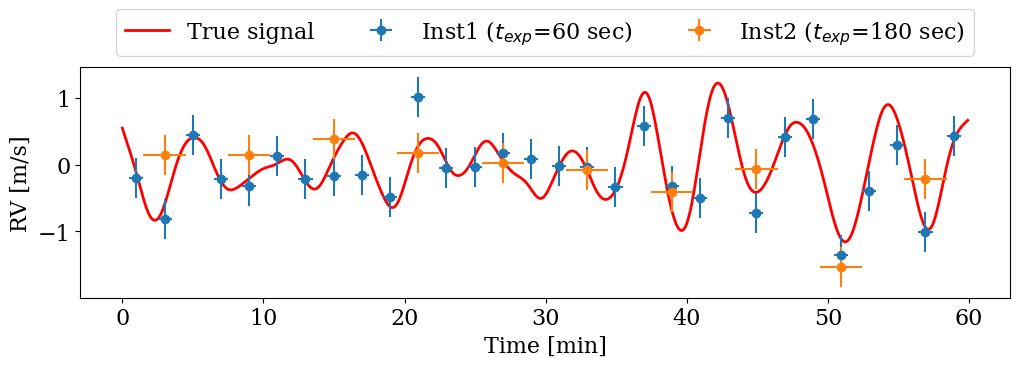

In [60]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
# ax.errorbar(tobs.value, y_inst,  yerr=yerr, fmt='o', color='grey')
# ax.errorbar(tobs.value, y_train, xerr=texp/60/2, yerr=yerr, fmt='o', color='k', label=r'$t_{exp}$=' + f'{texp} sec')
for instid in range(Ninst):
    inst = (instids==instid)
    ax.errorbar(tobs.value[inst], y_train[inst], xerr=texp_train[inst]/60/2, yerr=yerr,
                 fmt='o', label=f'Inst{instid+1} ($t_{{exp}}$={texp_train[inst][0]} sec)')

ax.legend(ncol=3, bbox_to_anchor=[0.5,1], loc='lower center')
ax.set(ylabel='RV [m/s]', xlabel=f'Time [{t.unit}]');

In [61]:
tmid = t_train # exposure midpoints

## Construct interleaved time array for integrated Kalman/RTS
ts = tmid - texp_train/2  # Exposure start times
te = tmid + texp_train/2  # Exposure end times
obsid = jnp.arange(len(tmid)).repeat(2)  # which observation does each time belong to

# Interleave start and end times into one array (fastest)
# https://stackoverflow.com/questions/5347065/interleaving-two-numpy-arrays-efficiently
t_states = np.empty((ts.size + te.size,), dtype=tmid.dtype)
t_states[0::2] = ts  # evens are start times
t_states[1::2] = te  # odds are end times
# Have to re-sort because exposures can overlap
sortidx  = jnp.argsort(t_states)
t_states = t_states[sortidx]
obsid    = obsid[sortidx] 
stateids = jnp.tile(jnp.array([0,1]), len(tmid))[sortidx] # 0 for t_s, 1 for t_e

In [62]:
print('k   t[s]    obs  inst  state')
print('----------------------------')
for k in range(len(t_states)):
    print(f'{k:<2d}  {t_states[k]:<7.1f}  {obsid[k]:<2}   {instids[obsid[k]]}   {stateids[k]}')
    if k>8:
        break

k   t[s]    obs  inst  state
----------------------------
0   30.0     0    0   0
1   90.0     0    0   1
2   90.0     2    1   0
3   149.8    1    0   0
4   209.8    1    0   1
5   269.7    3    0   0
6   270.0    2    1   1
7   329.7    3    0   1
8   389.5    4    0   0
9   449.4    6    1   0


## Run integrated solver

In [63]:
# Kalman filters
kalman_results = kalman_filter_integrated(t_states, y_train, texp_train, 
                                          obsid, instids, stateids, 
                                          R, H)
                                          
m_filtered_int, P_filtered_int, m_predicted_int, P_predicted_int = kalman_results

# RTS smoother
m_smooth_int, P_smooth_int = rts_smoother_integrated(t_states, obsid, instids, stateids,
                                                     m_filtered_int,  P_filtered_int, 
                                                     m_predicted_int, P_predicted_int)

In [64]:
k = 0
print(f'(k={k}) |', ['Start of obs', 'End of obs'][stateids[k]], obsid[k], f'(Inst: {instids[obsid[k]]})')
print('State:    ', "[x x'" + ''.join([f" z{i} z{i}" for i in range(Ninst)]) + ']')
print('----------------------------')
print('Predicted:', m_predicted_int[k])
print('Filtered: ', m_filtered_int[k])
print('Smoothed: ', m_smooth_int[k])

(k=0) | Start of obs 0 (Inst: 0)
State:     [x x' z0 z0 z1 z1]
----------------------------
Predicted: [0. 0. 0. 0. 0. 0.]
Filtered:  [0. 0. 0. 0. 0. 0.]
Smoothed:  [ 1.59685793e-01 -6.47741666e-03  0.00000000e+00  0.00000000e+00
 -1.65120116e-16  4.40591571e-17]


In [65]:
print('Predicted:\n', P_predicted_int[k])
print('Filtered:\n', P_filtered_int[k])
print('Smoothed:\n', P_smooth_int[k])

Predicted:
 [[3.51132600e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.33518171e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
Filtered:
 [[3.51132600e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.33518171e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.0000000

In [66]:
# Project predictive mean/var to observation space
H_n = lambda n: H / texp_train[n]  ## observation model at exposure n

## Augmented observation model
# C_k = lambda k: jnp.hstack([jnp.zeros_like(H_n(obsid[k])), H_n(obsid[k])]) # for integral state
# C_k = lambda k: jnp.hstack([H, jnp.zeros_like(H)]) # for instantaneous state    
def C_k(k):
    n = obsid[k]
    # H_k = H_n(n)
    Ck = jax.lax.dynamic_update_slice(jnp.zeros(d*(1+Ninst)), jnp.array([1.,0.])/texp_train[n], (d*(1+instids[n]),))
    return jnp.array([Ck])
C_k = jax.vmap(C_k)(jnp.arange(len(t_states)))

In [67]:
# y_ss = jnp.array([H_k[k] @ m_smooth_int[k].T for k in range(N)]).squeeze()
# yvar_ss = jnp.array([H_k[k] @ P_smooth_int[k] @ H_k[k].T for k in range(N)]).squeeze()

## Extract observed integral state for computing residuals
K = len(m_smooth_int)
y_ss = jnp.array([C_k[k] @ m_smooth_int[k].T for k in range(K)]).squeeze()
yvar_ss = jnp.array([C_k[k] @ P_smooth_int[k] @ C_k[k].T for k in range(K)]).squeeze()

# extract the end-states and put into original order (i.e. that matches t_train)
end_states = stateids==1
y_ss    = y_ss[end_states][obsid[end_states]]
yvar_ss = yvar_ss[end_states][obsid[end_states]]

In [68]:
# y_ss = (Hbar @ m_smooth_int.T).squeeze()
# yvar_ss = (Hbar @ P_smooth_int @ Hbar.T).squeeze()
yerr_ss = jnp.sqrt(yvar_ss)

In [69]:
# Predict at test times using both the instantaneous start/end smoothed states
mu_ss, var_ss = predict_at_times_integrated(m_smooth_int,    P_smooth_int, 
                                            m_filtered_int,  P_filtered_int,
                                            m_predicted_int, P_predicted_int,
                                            t_states, t_test, 
                                            Htest=None)
std_ss = jnp.sqrt(var_ss)

In [70]:
np.all(np.isfinite(m_predicted_int)),\
np.all(np.isfinite(m_filtered_int)),\
np.all(np.isfinite(m_smooth_int))

(np.True_, np.True_, np.True_)

In [71]:
np.all(np.isfinite(P_predicted_int)),
np.all(np.isfinite(P_filtered_int)),
np.all(np.isfinite(P_smooth_int))

np.True_

In [72]:
np.all(np.isfinite(mu_ss)), np.all(np.isfinite(std_ss))

(np.True_, np.True_)

### GP version for comparison

In [73]:
diag = yerr**2 

# Exposure start, mid, endtimes
texps = u.Quantity(texp_train, 's')
tstart, tend = (tobs - texps/2).to('s').value, (tobs + texps/2).to('s').value

### integrated prediction at data points 
zeros = jnp.zeros_like(t_train) # for instid
texp_pred = u.Quantity(texp_train, 's') # use exposure time
tup = (tobs, jnp.zeros_like(tobs), texp_pred)
### instantaneous prediction on test grid
ts = u.Quantity(t_test, 's').to('min')
zeros = jnp.zeros_like(t_test) # for instid
zeroexp = u.Quantity(jnp.zeros_like(t_test), 's') # for instantaneous curve
tups = (ts, zeros, zeroexp)
### Full GP predictions
sho_intkern = gpkernels.IntegratedOscillationKernel()
gp = tinygp.GaussianProcess(sho_intkern, tup, diag=diag)
y_gp, yvar_gp = gp.predict(y_train, tup,  return_var=True)
mu_gp, var_gp = gp.predict(y_train, tups, return_var=True)
yerr_gp = jnp.sqrt(yvar_gp)
std_gp  = jnp.sqrt(var_gp)

Defaulting to solar values.


## Comparison plot

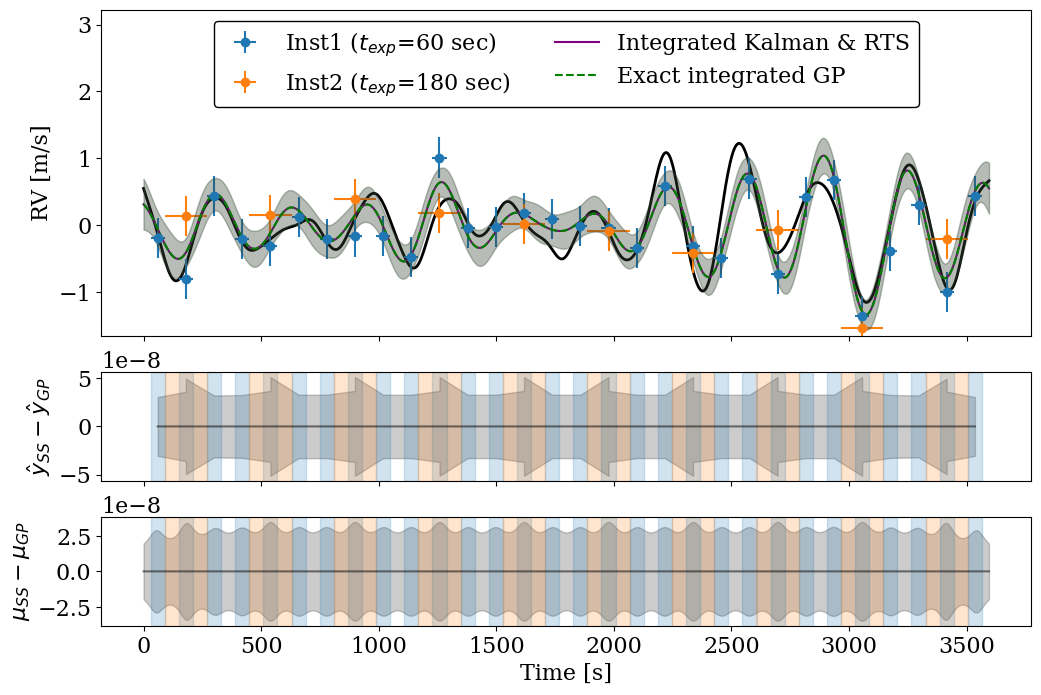

In [74]:
fig, (ax, rax, rrax) = plt.subplots(3,1, figsize=(12, 8), sharex=True, 
                                    gridspec_kw={'height_ratios':[3,1,1]})

css = 'purple'

lines = []
l1, = ax.plot(t.to(kernel.tunit).value, f(t), label='True signal', color='k', lw=2)
# lines.append(l1)
# ax.errorbar(tobs.value, y_inst,  yerr=yerr, fmt='o', color='grey')
# l2 = ax.errorbar(t_train, y_train, xerr=texp_train/2, yerr=yerr, fmt='o', 
#                  color='k', label=r'$t_{exp}$=' + f'{texp} sec')
# lines.append(l2)
for instid in range(Ninst):
    inst = (instids==instid)
    l2 = ax.errorbar(t_train[inst], y_train[inst], xerr=texp_train[inst]/2, yerr=yerr,
                 fmt='o', label=f'Inst{instid+1} ($t_{{exp}}$={texp_train[inst][0]} sec)')
    lines.append(l2)

## State space version
# _, = ax.plot(t_train, y_ss, 'o',  color=css,  ls='-', zorder=2)
# ax.fill_between(t_train, y_ss-yerr_ss, y_ss+yerr_ss, zorder=2, color=css, alpha=0.2)
l3, = ax.plot(t_test, mu_ss, color=css, label="Integrated Kalman & RTS", ls='-')
ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, zorder=2, color=css, alpha=0.2)

## Full GP version
# _, = ax.plot(t_train, y_gp, 'o', color=cgp,   ls='--',)
# ax.fill_between(t_train, y_gp-yerr_gp, y_gp+yerr_gp, color=cgp, alpha=0.2)
l4, = ax.plot(t_test, mu_gp, color=cgp,   ls='--', label="Exact integrated GP")
ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, zorder=2, color=cgp, alpha=0.2)

# rax.plot(t_train, y_ss - y_true, color=css, ls='-')
# rax.plot(t_train, y_gp - y_true, color=cgp, ls='--')
# rax.fill_between(t_train, y_ss-yerr_ss - y_true, y_ss+yerr_ss - y_true, ls='-',  color=css, alpha=0.2)
# rax.fill_between(t_train, y_gp-yerr_gp - y_true, y_gp+yerr_gp - y_true, ls='--', color=cgp, alpha=0.2)
rax.plot(t_train, y_ss - y_gp, ls='-', color='k', alpha=0.5)
rax.fill_between(t_train, (y_ss-yerr_ss) - (y_gp-yerr_gp), (y_ss+yerr_ss) - (y_gp+yerr_gp), ls='-', color='k', alpha=0.2)
for n, (t1, t2) in enumerate(zip(tstart, tend)):
    rax.axvspan(t1, t2, color=f'C{instids[n]}', alpha=0.2)
rax.set(ylabel=r'$\hat{y}_{SS}- \hat{y}_{GP}$')

mu_true = f(u.Quantity(t_test/60, 'min'))
# rrax.plot(t_test, mu_gp - mu_true, ls='-', color=cgp, alpha=1)
# rrax.fill_between(t_test, mu_gp-std_gp - mu_true, mu_gp+std_gp - mu_true, ls='-', color=cgp, alpha=0.2)
# rrax.plot(t_test, mu_ss - mu_true, ls='-', color=css, alpha=0.5)
# rrax.fill_between(t_test, mu_ss-std_ss - mu_true, mu_ss+std_ss - mu_true, ls='-', color=css, alpha=0.2)
# rrax.set(ylabel=r'$\mu - \mu_{true}$')

rrax.plot(t_test, mu_ss - mu_gp, ls='-', color='k', alpha=0.5)
rrax.fill_between(t_test, (mu_ss-std_ss) - (mu_gp-std_gp), (mu_ss+std_ss) - (mu_gp+std_gp), ls='-', color='k', alpha=0.2)
for n, (t1, t2) in enumerate(zip(tstart, tend)):
    rrax.axvspan(t1, t2, color=f'C{instids[n]}', alpha=0.2)
rrax.set(ylabel=r'$\mu_{SS}- \mu_{GP}$')

lines.extend([l3, l4])
ax.legend(lines, [l.get_label() for l in lines],
            ncol=2, loc='upper center', framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
ax.set_ylim(f(t).min()-.5, f(t).max()+2)
ax.set(ylabel='RV [m/s]');
# rax.set(ylabel=r'$\hat{y}-\hat{y}_\mathrm{true}$')
rrax.set(xlabel=f'Time [{kernel.tunit}]');
plt.savefig('/Users/rrubenzahl/Desktop/figures/ss_vs_gp_integrated.png', dpi=300, bbox_inches='tight')

In [75]:
in_exposure = jnp.zeros_like(t_test, dtype=bool)
for t1, t2 in zip(t_states[0::2], t_states[1::2]):
    in_exposure = in_exposure | ((t_test >= t1) & (t_test <= t2))

In [76]:
np.mean(mu_gp[~in_exposure] - mu_ss[~in_exposure])

Array(1.35276008e-14, dtype=float64)

In [77]:
mu_gp[-1]-mu_ss[-1]

Array(1.55431223e-15, dtype=float64)

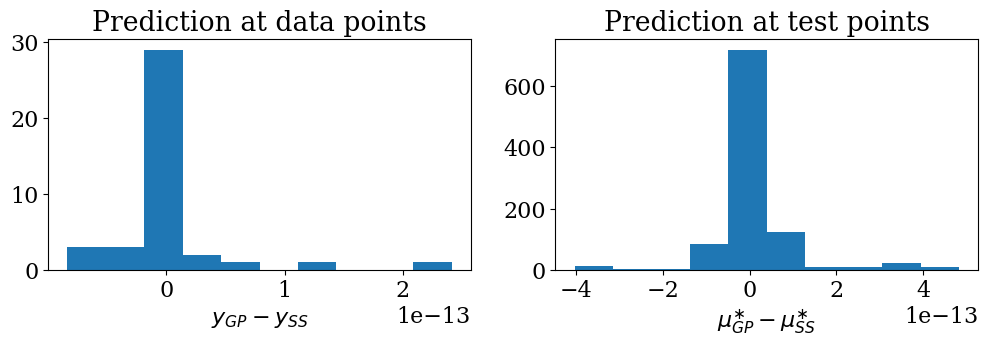

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.hist(y_gp - y_ss);
ax1.set(title='Prediction at data points', xlabel='$y_{GP} - y_{SS}$');

maxerr = jnp.nanpercentile(jnp.abs(mu_gp-mu_ss), 99)
ax2.hist(mu_gp - mu_ss);
ax2.set(title='Prediction at test points', xlabel=r'$\mu^{\ast}_{GP} - \mu^{\ast}_{SS}$');

# 8. Constructing a kernel from component kernels

## 8.1 Sum of kernels

In the GP framework, a sum of covariance kernels yields another covariance kernel
\begin{align}
\bm{K} = \bm{K}_1 + \bm{K}_2 + ... + \bm{K}_M = \sum_{m=0}^{M} \bm{K}_m \nonumber
\end{align}

In the SDE representation, sums of stationary covariance functions can be constructed by stacking the model in a block-diagonal representation ([Algorithm 12.9 (pdf page 273) in S&auml;rkk&auml; and Solin 2019](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf)):

\begin{align}
\bm{F} &= \text{blkdiag}(\bm{F}_1, \bm{F}_2, ...),      &       \bm{L}   &= \text{blkdiag}(\bm{L}_1, \bm{L}_2, ...), \nonumber \\
\bm{Q} &= \text{blkdiag}(\bm{Q}_1, \bm{Q}_2, ...),      &       \bm{P}_\infty &= \text{blkdiag}(\bm{P}_{\infty,1}, \bm{P}_{\infty,2}, ...), \nonumber
\end{align}

The matrix exponential $\Phi(\Delta) = \exp(F \Delta)$ is also simply the block diagonal matrix of component matrix exponentials, per the definition of the matrix exponential:
\begin{align*}
\bm{\Phi}(\Delta) &= \exp(\bm{F}\Delta) \\
                  &= \exp(\text{blkdiag}(\bm{F}_1, \bm{F}_2, ...) \Delta) \\
                  &= \text{blkdiag}(\bm{F}_1\Delta, \bm{F}_2\Delta, ...) \\
                  &= \text{blkdiag}(\bm{\Phi}_1, \bm{\Phi}_2, ...)(\Delta)
\end{align*}

The rest of the machinery (Kalman/RTS) proceeds as before. Each component is therefore treated as independent dynamics in the state propagation, and become coupled by the measurement model $\bm{H} = (\bm{H1} \;\bm{H2}\; ...)$. 

## 8.2 Product of kernels

[Algorithm 12.10 (pdf page 273) in S&auml;rkk&auml; and Solin 2019](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf) gives the machinery for constructing a kernel from the product of component kernels:
\begin{align*}
\bm{F} = \bm{F}_1 \otimes \bm{I} + \bm{F}_2 \otimes \bm{I} ...,      
\end{align*}

\begin{align*}
\bm{L} &= \bm{L}_1 \otimes \bm{L}_2 ..., & \bm{P}_\infty &= \bm{P}_{\infty,1} \otimes \bm{P}_{\infty,2} ... \\
\bm{Q} &= \bm{Q}_1 \otimes \bm{Q}_2 ..., & \bm{H} &= \bm{H} \otimes \bm{H} ...
\end{align*}
where $\otimes$ is the Kronecker product (which also yields block matrices). In this case, the matrix exponential $\Phi(\Delta) = \exp(F \Delta)$ becomes the Kronecker product of the two matrix exponentials 
\begin{align*}
\bm{\Phi}(\Delta) &= \exp(\bm{F}\Delta) \\
                  &= \exp(\bm{F}_1 \Delta \otimes \bm{I} + \bm{F}_2 \Delta \otimes \bm{I} ...) \\
                  &= \bm{\Phi}_1(\Delta) \otimes \bm{\Phi}_2(\Delta) ...
\end{align*}

The rest of the machinery (Kalman/RTS) proceeds as before, and the final result in the observed space again uses the coupled measurement model $\bm{H} = (\bm{H1} \;\bm{H2}\; ...)$. 

In [392]:
# tinygp does this by defining a `Block` object as a type of quasisep solver 
#   that overwrites the various matrix operations (__mul__, to_dense, transpose, etc.) 
#   those are then what the quasisep solver uses when doing the matrix algebra.
# Then defines a Sum(Quasisep) object of the same form as the actual Quasisep objects
#   but where each component matrix is a Block of the two components. 
#   Then, the Quasisep object has __add__ overwritten to use this Sum(self, other)

In [393]:
class Sum(Quasisep):
    """A helper to represent the sum of two quasiseparable kernels"""

    kernel1: Quasisep
    kernel2: Quasisep

    def coord_to_sortable(self, X: JAXArray) -> JAXArray:
        """We assume that both kernels use the same coordinates"""
        return self.kernel1.coord_to_sortable(X)


    def design_matrix(self) -> JAXArray:
        return Block(self.kernel1.design_matrix(), self.kernel2.design_matrix())

    def stationary_covariance(self) -> JAXArray:
        return Block(
            self.kernel1.stationary_covariance(),
            self.kernel2.stationary_covariance(),
        )

    def observation_model(self, X: JAXArray) -> JAXArray:
        return jnp.concatenate(
            (
                self.kernel1.observation_model(X),
                self.kernel2.observation_model(X),
            )
        )

    def transition_matrix(self, X1: JAXArray, X2: JAXArray) -> JAXArray:
        return Block(
            self.kernel1.transition_matrix(X1, X2),
            self.kernel2.transition_matrix(X1, X2),
        )


NameError: name 'Quasisep' is not defined

# 9. Kalman/RTS predictive mean/variance for a single component kernel

Say the kernel is a sum of $M$ component kernels

\begin{align}
\bm{K} = \bm{K}_1 + \bm{K}_2 + ... + \bm{K}_M = \sum_{m=0}^{M} \bm{K}_m \nonumber
\end{align}

In GP regression, we can compute the predictive mean and variance from any of the individual kernel components as

\begin{align}
\mu_{m, GP} &= \bm{K}_{m, \ast}^T (\bm{K} + \bm{N})^{-1} \bm{y}     \nonumber \\
\text{Cov}_{m, GP} &= \bm{K}_{m,\ast\ast} - \bm{K}_{m,\ast}^T (\bm{K} + \bm{N})^{-1} \bm{K}_{m,\ast}.  \nonumber
\end{align}

Basically, wherever the kernel is computed with test points, we only use the component kernel of interest. It is then true that

\begin{align}
\mu_{GP} &= \sum_{m=0}^M \mu_{m, GP}     \nonumber \\
\text{Cov}_{GP} &= \sum_{m=0}^M \text{Cov}_{m, GP}.  \nonumber
\end{align}

To do the same in the state space framework, recall that the structure of a sum/product of kernels given in Section 8 treates the dynamics of each component as independent (the matrices are combined in block diagonal form). Thus, the Kalman/RTS algorithms by construction provide us with all of the component means and variances, which get summed together when projecting through the coupled observation matrix $\bm{H} = (\bm{H1} \;\bm{H2}\; ...)$. To just pick out one component, we can simply do
\begin{align*}
\mu_{m, GP}        &= \bm{H}_m \hat{m}_m^T     \nonumber \\
\text{Cov}_{m, GP} &= \bm{H}_m \hat{P}_m \bm{H}_m^T  \nonumber
\end{align*}
where
\begin{align*}
\bm{H}_m  = (0,...,H_m,...,0) \\
\end{align*}
picks out just the observation matrix for the component of interest.